# **Meta 1**

Simular no software CoppeliaSim um robô móvel com
acionamento diferencial, de maneira que o mesmo receba os
comandos das velocidades de referências para as rodas e retorne a
posição e orientação do robô ($x,y,\theta$) em um referencial global.

Além do movimento do robô no espaço de trabalho, mostrar os seguintes gráficos: 
* Velocidades das rodas (entradas) em função do tempo; 
* Configuração do robô ($x,y,\theta$), (saídas), em função do tempo;
* Gráfico das posições ($x(t),y(t)$) seguidas pelo robô no plano $xy$.

https://manual.coppeliarobotics.com/

https://manual.coppeliarobotics.com/en/remoteApiFunctionsPython.htm

Obs.: Inserir as seguintes linhas ao script do robô para ser desenhado o caminho

```lua
--lua

sim = require('sim')

function sysCall_init()
    robot = sim.getObject('.')
    robotTrace = sim.addDrawingObject(sim.drawing_linestrip + sim.drawing_cyclic, 8, 0, -1, 400, {1, 1, 0}, nil, nil, {1, 1, 0})
end

function sysCall_sensing()
    local p = sim.getObjectPosition(robot)
    p[3]=0
    sim.addDrawingObjectItem(robotTrace, p)
end 
```


In [3]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import numpy as np
import matplotlib.pyplot as plt
import guira

In [4]:
def AngleWrap(ang):
	if ang > np.pi:
		return ang - 2 * np.pi
	elif ang < -np.pi:
		return ang + 2 * np.pi
	else:
		return ang

Program started
Connected to remote API server


Condições iniciais [-0.00074799 -0.00056652  0.00080396]
[6.90504763 3.35031079]
Condições Finais [   0.51420879    0.87099612 -177.90267248]


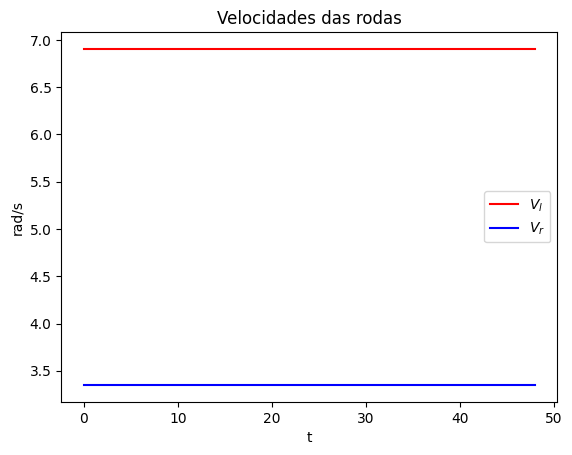

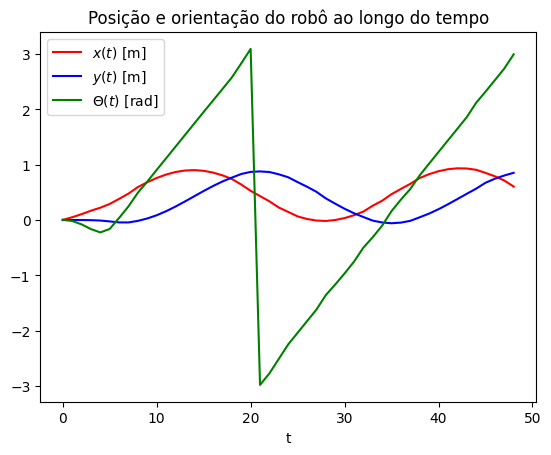

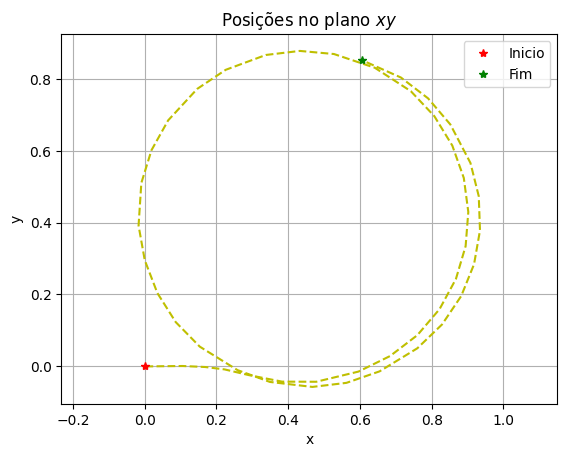

Program ended


In [6]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1)
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    #Haandle do Robô
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)  

    #Handles das rodas   
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)    

    # Específico do robô
    L = 0.331   #Metros
    r = 0.09751 #Metros

    # Velocidades desejadas (linear, angular)
    v = 0.5    # m/s
    w = 60    # °/s
    w = np.deg2rad(w) #rad/s

    #Condições iniciais do Robô
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
    returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    q = np.array([pos[0], pos[1], ori[2]])
    print("Condições iniciais", q)

    # Cinemática Inversa das rodas 
    wr = ((2.0*v) + (w*L))/(2.0*r)
    wl = ((2.0*v) - (w*L))/(2.0*r)    
    u = np.array([wr, wl], dtype=float)
    print(u)

    #Listas que conterão as posições e orietações (poses) do robô
    lx = list()
    ly = list()
    lt = list()

    #Listas que conterão as velocidades de cada roda.
    lwl = list()
    lwr = list()

    # Lembrar de habilitar o 'Real-time simulation' (CoppeliaSim Edu >> Simulation >> Real-time simulation)
    startTime=time.time()
    lastTime = startTime
    t = 0

    while True:

        now = time.time()
        dt = now - lastTime

        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, r_wheel, u[0], sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, l_wheel, u[1], sim.simx_opmode_oneshot_wait)
        

        #Cinemática Direta
        M = np.array([[r*np.cos(q[2])/2, r*np.cos(q[2])/2], 
                      [r*np.sin(q[2])/2, r*np.sin(q[2])/2],
                        [r/L, -r/L]])
        q = q + (M @ u)*dt
        q[2]= AngleWrap(q[2])
        
        #Obtenção da posição do Robô
        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
        returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        Xr = np.array([pos[0], pos[1], (ori[2])])

        #poses
        lx.append(pos[0])
        ly.append(pos[1])
        lt.append(ori[2])

        #velocidades
        lwl.append(u[0])       
        lwr.append(u[1])

        t = t + dt        
        lastTime = now
        if (t>10):
             sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
             sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)
             break
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
    returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    qf = np.array([pos[0], pos[1], np.rad2deg(ori[2])])
    print("Condições Finais",qf)  
    
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    #sim.simxStopSimulation(clientID, sim.simx_opmode_blocking)

    #Graficos 
    plt.title("Velocidades das rodas")
    plt.plot(lwl,'r-',label='$V_l$')
    plt.plot(lwr,'b-',label='$V_r$')
    plt.xlabel("t")
    plt.ylabel("rad/s")
    plt.legend()
    plt.show()

    plt.title("Posição e orientação do robô ao longo do tempo")
    plt.plot(lx,'r-',label='$x(t)$ [m]')
    plt.plot(ly,'b-',label='$y(t)$ [m]')
    plt.plot(lt,'g-',label='$\Theta(t)$ [rad]')
    plt.xlabel("t")
    plt.legend()
    plt.show()

    plt.title("Posições no plano $xy$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(lx,ly,"--y")
    plt.plot(lx[0],ly[0],"*r", label= "Inicio")
    plt.plot(lx[len(lx)-1],ly[len(ly)-1],"*g", label= "Fim")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

# **Meta 02**

Implementar controlador cinemático de posição para o robô móvel que leve o robô a uma posição final especificada.
* Obter resultados de simulação (caminho seguido pelo robô, gráficos das variáveis de entrada e saída em função do tempo, etc.).

In [26]:
def normalize_angle(angle):
    while angle <= -np.pi/2:
        angle += np.pi
    while angle > np.pi/2:
        angle -= np.pi
    return angle

# Controle de posição do robô.
def getPositioningControl(q,ref):

    dx = ref[0]-q[0]
    dy = ref[1]-q[1]
    
    theta_ref = np.arctan2(dy,dx)
    erro_theta = theta_ref - q[2] 
    erro_theta = AngleWrap(erro_theta)
    #erro_theta = normalize_angle(erro_theta)
   
    dl = np.sqrt(dx**2 + dy**2)*np.cos(erro_theta)

    k1 = 0.1
    k2 = 0.2
    
    v = k1*(dl)
    w = k2*(erro_theta)
    return [v,w]

def getMovingReference(q , qd):
    dx = qd[0] - q[0]
    dy = qd[1] - q[1]
    betta = np.arctan2(dy,dx)
    delta_d = np.sqrt(dx**2 + dy**2)

    gamma =  betta - qd[2]
    gamma = normalize_angle(gamma)

    x_ref = q[0] + delta_d * np.cos(betta - gamma)
    y_ref = q[1] + delta_d * np.sin(betta - gamma)
    
    return [x_ref , y_ref]

def getPoseControl(q,goal):
    ref = getMovingReference(q , goal)
    #input("")
    print(ref)
    v,w = getPositioningControl(q, goal)
    return [v, w, ref]

In [29]:
####################################################################################
#                                                                                  #
#                 LEMBRE-SE QUE A SIMULAÇÃO DEVE ESTAR EM EXECUÇÃO!                #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1)
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    # Handle do Robô
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)  

    # Handles das rodas   
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait) 

    
    # Goal (x, y, theta)    
    qgoal = np.array([1,1, np.deg2rad(180)])
    
    # Handle do Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)     
    returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qgoal[0], qgoal[1], 0], sim.simx_opmode_oneshot_wait)
    returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)
       

    # Específico do robô
    L = 0.331   #Metros
    r = 0.09751 #Metros

    #Listas que conterão as posições e orietações (poses) do robô
    lx = list()
    ly = list()
    lt = list()
    lxref = list()
    lyref = list()

    #Listas que conterão as velocidades de cada roda.
    lwl = list()
    lwr = list()

    # Lembrar de habilitar o 'Real-time simulation' (CoppeliaSim Edu >> Simulation >> Real-time simulation)
    startTime=time.time()
    lastTime = startTime
    t = 0

    while True:

        now = time.time()
        dt = now - lastTime

        #Obtenção da posição do Robô
        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
        returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        q = np.array([pos[0], pos[1], AngleWrap(ori[2])])
        #print(q)

        #poses
        lx.append(pos[0])
        ly.append(pos[1])
        lt.append(ori[2])

        #Controle
        v, w, ref = getPoseControl(q, qgoal)


        lxref.append(ref[0])
        lyref.append(ref[1])


        # Cinemática Inversa das rodas 
        wr = ((2.0*v) + (w*L))/(2.0*r)
        wl = ((2.0*v) - (w*L))/(2.0*r)    

        # Enviando velocidades
        sim.simxSetJointTargetVelocity(clientID, r_wheel, wr, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, l_wheel, wl, sim.simx_opmode_oneshot_wait)

        #velocidades
        lwl.append(wl)       
        lwr.append(wr)
       
        t = t + dt        
        lastTime = now
        if (np.sqrt((qgoal[0]-q[0])**2 +(qgoal[1]-q[1])**2 )<=0.05 or t>30):
             sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
             sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)
             break
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)        
    returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    #qf = np.array([pos[0], pos[1], np.rad2deg(ori[2])])

    
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    #sim.simxStopSimulation(clientID, sim.simx_opmode_blocking)

    #Graficos 
    plt.title("Velocidades das rodas")
    plt.plot(lwl,'r-',label='$w_l$')
    plt.plot(lwr,'b-',label='$w_r$')
    plt.xlabel("t")
    plt.ylabel("rad/s")
    plt.legend()
    plt.show()

    plt.title("Posição e orientação do robô ao longo do tempo")
    plt.plot(lx,'r-',label='$x(t)$ [m]')
    plt.plot(ly,'b-',label='$y(t)$ [m]')
    plt.plot(lt,'g-',label='$\Theta(t)$ [rad]')
    plt.xlabel("t")
    plt.legend()
    plt.show()

    plt.title("Posições no plano $xy$")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(lx,ly,"--y")
    plt.plot(lx[0],ly[0],"*b", label= "Inicio")
    plt.plot(qgoal[0],qgoal[1],"ok",label="Goal")
    plt.plot(lx[len(lx)-1],ly[len(ly)-1],"*g", label= "Fim")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()

    plt.title("Referencia Variavel")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(lx,ly,"--y")
    plt.plot(lxref,lyref,"r.")
    plt.plot(qgoal[0],qgoal[1],"ok",label="Goal")
    plt.plot(lxref,lyref,"r.",label= "Ref. var.")
    plt.plot(lxref[0],lyref[0],"r*")
    plt.plot(lx[0],ly[0],"*b", label= "Inicio")
    plt.plot(lx[len(lx)-1],ly[len(ly)-1],"*g", label= "Fim")
    plt.axis('equal')
    plt.legend()
    plt.grid()
    plt.show()
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

Program started
Failed connecting to remote API server
Program ended


# **Meta 03**

Implementar gerador de caminho baseado em polinômios interpoladores de 3º grau para robô móvel.

* Incluir gerador de caminho na simulação. O simulador deve permitir mostrar o caminho gerado sobre a tela do espaço de trabalho do CoppeliaSim. 
* Usar o controlador da meta 2 para seguir o caminho especificado. 
* Obter resultados de simulação (caminho gerado, caminho seguido, gráficos das variáveis de entrada e saída em função do tempo, etc.)